# 目标：通过计算计算广告点击率，使用A/B实验来对两组营销策略广告投放效果。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1、字段说明：
- dt: 表示时间日志，暂时无用
- user_id: 用户编号
- label: 用户是否点击该广告
- dmp_id: 别是营销策略，其中1表示对照组（没有营销）、2表示营销策略一，3表示营销策略二

In [2]:
data = pd.read_csv("data/effect_tb.csv",encoding='utf-8',header=None)
data.columns = ['dt','user_id',"label","dmp_id"]
data = data.drop(columns = 'dt')
data.head(5)

,user_id,label,dmp_id
0,1,0,1
1,1000004,0,1
2,1000004,0,2
3,1000006,0,1
4,1000006,0,3


In [3]:
data.describe()

,user_id,label,dmp_id
count,2.645958e+06,2.645958e+06,2.645958e+06
mean,3.112995e+06,1.456297e-02,1.395761e+00
std,1.828262e+06,1.197952e-01,6.920480e-01
min,1.000000e+00,0.000000e+00,1.000000e+00
25%,1.526772e+06,0.000000e+00,1.000000e+00
50%,3.062184e+06,0.000000e+00,1.000000e+00
75%,4.721132e+06,0.000000e+00,2.000000e+00
max,6.265402e+06,1.000000e+00,3.000000e+00


## 2、数据预处理

### 2.1 重复值处理
- duplicated(keep=first/last/False) 检查是否重复,first表示第一次出现为True，last表示最后一次出现为True，False表示将所有存在重复的行都标记为True，只有唯一值的行才标记为False，这种方法会丢失一些值。
- nunique() 表示每一列唯一值的数量

In [4]:
data.shape

(2645958, 3)

In [5]:
data.duplicated().sum()

12983

In [6]:
data.nunique()  ##唯一值的个数

user_id    2410683
label            2
dmp_id           3
dtype: int64

In [7]:
data.drop_duplicates(inplace=True,)
data.duplicated(keep=False).sum()   ##说明所有的值都是没有重复的，并且都是唯一出现的

0

In [8]:
## 将索引重置
data=data.reset_index(drop=True)

In [9]:
data.isnull().sum()   ##没有空值

user_id    0
label      0
dmp_id     0
dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2632975 entries, 0 to 2632974
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   label    int64
 2   dmp_id   int64
dtypes: int64(3)
memory usage: 60.3 MB


### 2.2 异常值检查
- 离散型特征：可以使用透视表，或者直接返回该特征的唯一值
- 连续性特征：使用箱线图来检查

In [14]:
data.pivot_table(index='dmp_id',columns='label',values='user_id',aggfunc='count',margins=True)

label,0,1,All
dmp_id,,,
1,1881745,23918,1905663
2,404811,6296,411107
3,307923,8282,316205
All,2594479,38496,2632975


##### 可以观察到label和dmp_id的值只有表中显示，表明没有异常值

In [ ]:
!pip install seaborn

In [18]:
import seaborn as sns

#### 使用箱线图来检查异常值

<Axes: >

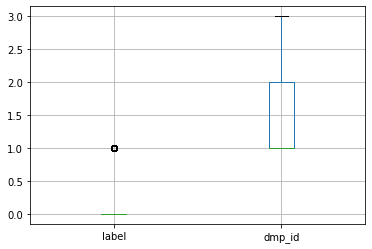

In [22]:
data.iloc[:,1:].boxplot()

## 3、样本容量实验
- 在A/B实验之前，要确保实验组的样本数量满足最小样本数
- 这是使用Evan Miller工具计算最小样本数量


### 3.1 首先我们要计算对照组的广告点击率作baseline

In [30]:
data[data['dmp_id']==1]['label'].mean()   ##点击的个数/对照组总样本数

0.012551012429794775

#### 以0.0126作为基准、在至少提升一个百分点的要求下，我们通过Evan miller工具计算所需要的最小样本数量为2167
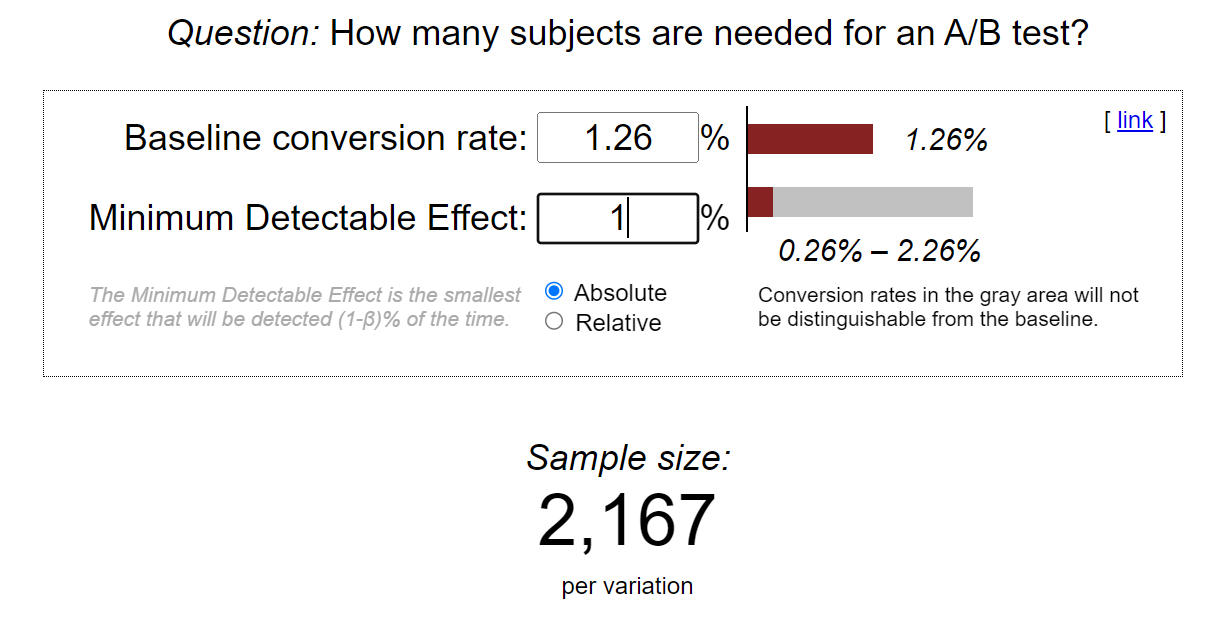

### 3.2 两个实验组的样本数量检查

In [32]:
data['dmp_id'].value_counts()

dmp_id
1    1905663
2     411107
3     316205
Name: count, dtype: int64

#### 两个实验组的样本数量分别为411107和316205，均满足2167的最小值

## 4、假设检验

#### 分别计算三组的点击率

In [34]:
print("对照组点击率：", data[data['dmp_id']==1]["label"].mean())
print("营销策略1点击率：", data[data['dmp_id']==2]["label"].mean())
print("营销策略2点击率：", data[data['dmp_id']==3]["label"].mean())

对照组点击率： 0.012551012429794775
营销策略1点击率： 0.015314747742072015
营销策略2点击率： 0.026191869198779274


#### 可以看出策略1和策略2均有提升，但是只有策略2满足1%的提升率，需要使用假设检验来判断提升是否显著